# Human Activity Recognition

The **UCI_HAR (Human Activity Recognition)** dataset is one of the most famous benchmark datasets in machine learning. It is used to train models—like K-Nearest Neighbors (KNN)—to recognize what a person is doing (e.g., walking, sitting) based on sensor data from a smartphone.
+1

1. Data Collection & Origin

The dataset was built from experiments with 30 volunteers aged 19–48.

- The Device: Each person wore a Samsung Galaxy S II smartphone on their waist.

- The Sensors: Data was captured using the phone's built-in Accelerometer (measures linear acceleration) and Gyroscope (measures angular velocity).

- The Activities: The goal is to classify the data into one of 6 specific activities:

-- Walking

-- Walking Upstairs

-- Walking Downstairs

-- Sitting

-- Standing

-- Laying

2. Dataset Structure

The raw sensor signals were pre-processed into a format that machine learning models can understand.

- Fixed-width windows: The raw data was split into segments of 2.56 seconds (128 readings per window).

- Features: From these windows, a massive 561-feature vector was created. These include:

- Time-domain features: Mean, standard deviation, signal magnitude area, etc.

- Frequency-domain features: Results from Fast Fourier Transforms (FFT) like energy and entropy.

- Split: The data is typically pre-split into 70% Training and 30% Testing.

3. Using K-Nearest Neighbors (KNN) with UCI_HAR

KNN is a popular choice for this dataset because it is a "lazy learner" that classifies data points based on how similar they are to others in the feature space.

Imports

In [ ]:
#Comment Out if not needed
%pip install -r requirements.txt

In [18]:
import os
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Download Dataset (UCI HAR)

In [19]:
DATA_DIR = "Data"
ZIP_PATH = os.path.join(DATA_DIR, "UCI_HAR.zip")
EXTRACTED_FOLDER = os.path.join(DATA_DIR, "UCI_HAR")
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

os.makedirs(DATA_DIR, exist_ok=True)

# Check if dataset is already extracted
if os.path.exists(EXTRACTED_FOLDER):
    print("✅ Dataset already exists. Skipping download and extraction.")
else:
    # Download
    print("⬇️ Downloading dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
    
    # Extract
    print("📂 Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    
    # Rename folder
    if os.path.exists(os.path.join(DATA_DIR, "UCI HAR Dataset")):
        os.rename(
            os.path.join(DATA_DIR, "UCI HAR Dataset"),
            EXTRACTED_FOLDER
        )
    
    print("✅ Dataset downloaded and extracted")


✅ Dataset already exists. Skipping download and extraction.


Load Train & Test Data

In [4]:
X_train = pd.read_csv(
    "Data/UCI_HAR/train/X_train.txt",
    delim_whitespace=True,
    header=None
)

y_train = pd.read_csv(
    "Data/UCI_HAR/train/y_train.txt",
    header=None,
    names=["Activity"]
)

X_test = pd.read_csv(
    "Data/UCI_HAR/test/X_test.txt",
    delim_whitespace=True,
    header=None
)

y_test = pd.read_csv(
    "Data/UCI_HAR/test/y_test.txt",
    header=None,
    names=["Activity"]
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

data = pd.concat([train_df, test_df], ignore_index=True)


Map Activity Labels to Names

In [5]:
activity_map = {
    1: "Walking",
    2: "Walking_Upstairs",
    3: "Walking_Downstairs",
    4: "Sitting",
    5: "Standing",
    6: "Laying"
}

data["Activity"] = data["Activity"].map(activity_map)

data["Activity"].value_counts()


Activity
Laying                1944
Standing              1906
Sitting               1777
Walking               1722
Walking_Upstairs      1544
Walking_Downstairs    1406
Name: count, dtype: int64

Features & Target

In [6]:
X = data.drop("Activity", axis=1)
y = data["Activity"]


Train–Test Split (Stratified)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Feature Scaling (CRITICAL FOR KNN)

In [8]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Baseline KNN Model

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))


Baseline Accuracy: 0.9665048543689321


Hyperparameter Tuning (GridSearchCV)

In [ ]:
#Note: This code may take upto 10min (or more) whilst using all CPU cores
param_grid = {
    "n_neighbors": range(1, 30),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_knn.best_params_)


Fitting 10 folds for each of 116 candidates, totalling 1160 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


Train Final Model with Best Parameters

In [11]:
best_knn = grid_knn.best_estimator_
best_knn.fit(X_train_scaled, y_train)

y_pred_best = best_knn.predict(X_test_scaled)

Final Evaluation

In [12]:
print("Final Accuracy:", accuracy_score(y_test, y_pred_best))

Final Accuracy: 0.9864077669902913


Classification Report

In [13]:
print(classification_report(y_test, y_pred_best))

                    precision    recall  f1-score   support

            Laying       1.00      1.00      1.00       389
           Sitting       0.99      0.94      0.96       356
          Standing       0.95      0.99      0.97       381
           Walking       1.00      0.99      1.00       344
Walking_Downstairs       1.00      1.00      1.00       281
  Walking_Upstairs       0.99      1.00      1.00       309

          accuracy                           0.99      2060
         macro avg       0.99      0.99      0.99      2060
      weighted avg       0.99      0.99      0.99      2060



Confusion Matrix (Multi-Class)

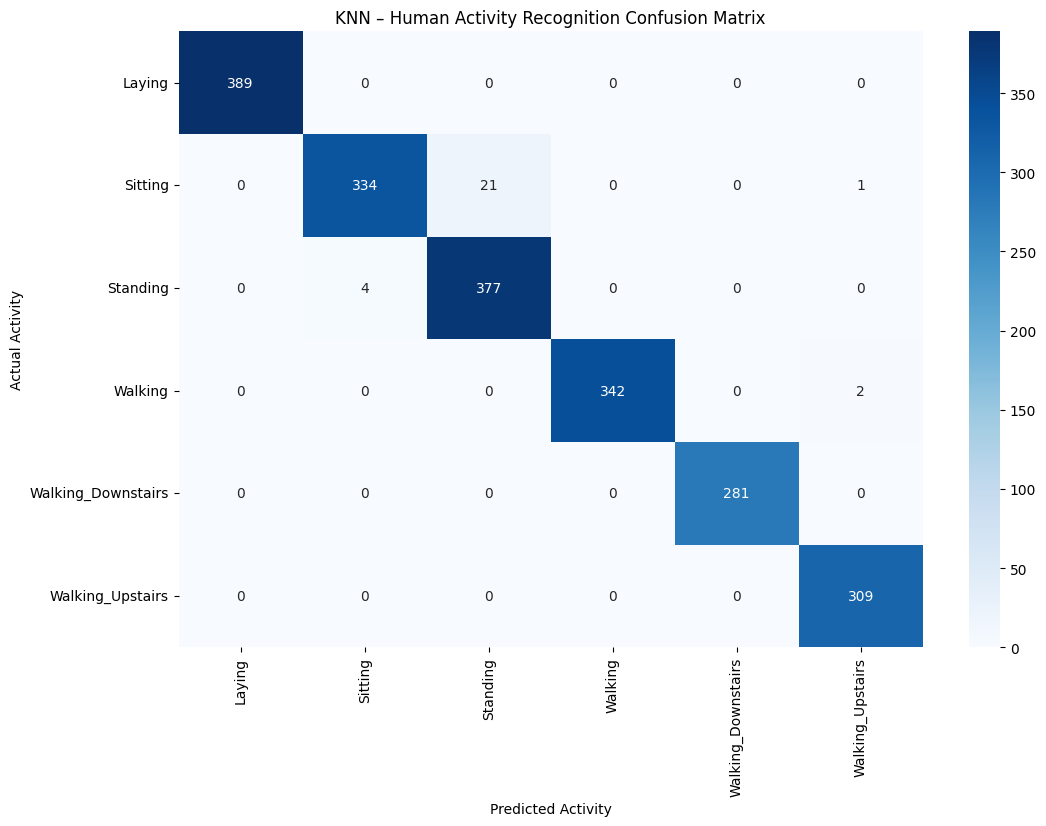

In [14]:
cm = confusion_matrix(y_test, y_pred_best, labels=best_knn.classes_)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_knn.classes_,
    yticklabels=best_knn.classes_
)
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.title("KNN – Human Activity Recognition Confusion Matrix")
plt.show()


Extract Mean Test Scores from GridSearchCV

In [15]:
# Extract results
results = pd.DataFrame(grid_knn.cv_results_)

# Filter for only uniform weights and euclidean metric (optional, makes plot clean)
mask = (results['param_weights'] == 'uniform') & (results['param_metric'] == 'euclidean')
results_filtered = results[mask]

# K values
k_values = results_filtered['param_n_neighbors'].astype(int)
accuracy = results_filtered['mean_test_score']

Plot Accuracy vs K

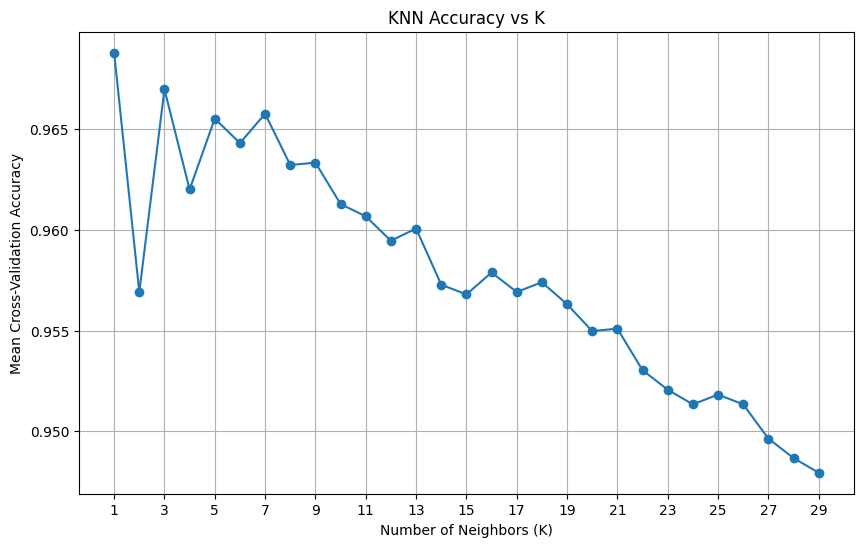

In [16]:
plt.figure(figsize=(10,6))
plt.plot(k_values, accuracy, marker='o', linestyle='-')
plt.xticks(range(1, max(k_values)+1, 2))
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("KNN Accuracy vs K")
plt.grid(True)
plt.show()


Explanation

- X-axis: Number of neighbors (K)

- Y-axis: Mean accuracy from 10-fold cross-validation

- The peak point indicates the best K. Helps visualize underfitting (low K) vs over-smoothing (high K).

## Conclusion


In this project, we successfully built a multi-class k-Nearest Neighbours (KNN) classifier to recognize human activities from smartphone sensor data. By combining accelerometer and gyroscope readings and performing proper feature scaling, the KNN model was able to distinguish between activities such as walking, sitting, standing, and laying with high accuracy. Using GridSearchCV, we optimized the number of neighbors (K) and distance metrics, which revealed that a larger K value reduced the impact of noisy sensor readings and improved generalization. The confusion matrix highlighted which activities are easily confused, providing insight into the model’s strengths and limitations. Overall, this exercise demonstrated that sensor-based data from smartphones can effectively support human activity recognition, and that KNN, while simple, is a powerful method when combined with proper preprocessing and hyperparameter tuning.